# Adaboost
For this exercise you will implement AdaBoost from scratch and applied it to a spam dataset. You will be classifying data into spam and not spam. You can call DecisionTreeClassifier from sklearn to learn your base classifiers.

Here is how you train a decision tree classifier with weights.

`
h = DecisionTreeClassifier(max_depth=1, random_state=0)
h.fit(X, Y, sample_weight=w)
`

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier

In [2]:
# accuracy computation
def accuracy(y, pred):
    return np.sum(y == pred) / float(len(y)) 

In [3]:
from numpy import copy
def parse_spambase_data(filename):
    """ Given a filename return X and Y numpy arrays

    X is of size number of rows x num_features
    Y is an array of size the number of rows
    Y is the last element of each row. (Convert 0 to -1)
    """
    data = np.genfromtxt(filename,delimiter=",", dtype = float)
    Y0 = data[:,data.shape[1]-1]
    X = data[:,:data.shape[1]-1]
    
    
    d = {0:-1}
    Y = copy(Y0)
    for k, v in d.iteritems(): Y[Y0==k] = v
    #raise NotImplementedError()
    return X, Y

In [4]:
y_test = np.array([1., -1., 1., 1., -1., -1., 1., 1., 1., -1.])
X, Y = parse_spambase_data("tiny.spam.train")
for i in range(len(y_test)): assert(y_test[i] == Y[i])
n, m = X.shape
assert(n == 10)
assert(m == 57)

In [5]:
def adaboost(X, y, num_iter):
    """Given an numpy matrix X, a array y and num_iter return trees and weights 
   
    Input: X, y, num_iter
    Outputs: array of trees from DecisionTreeClassifier
             trees_weights array of floats
    Assumes y is {-1, 1}
    """
    trees = []
    trees_weights = [] 
    N, _ = X.shape
    d = np.ones(N)
    dic = {0:1}
    for i in range(num_iter):
        h = DecisionTreeClassifier(max_depth=1, random_state=0)
        h.fit(X, y, sample_weight=d)
        result = np.absolute(h.predict(X)-y)/2
        error = np.sum(result*d)/np.sum(d)
        if error == 0:
            alpha = 1
        else: 
            alpha = np.log(((1-error)/error))
        result = result * np.exp(alpha)
        d_multiplier = copy(result)
        for k, v in dic.iteritems(): d_multiplier[result==k] = v
        d = d*d_multiplier
        trees_weights.append(alpha)
        trees.append(h)
    # YOUR CODE HERE
    #raise NotImplementedError()
    return trees, trees_weights

In [6]:
X, Y = parse_spambase_data("tiny.spam.train")
trees, weights = adaboost(X, Y, 2)
assert(len(trees) == 2)
assert(len(weights) == 2)
assert(isinstance(trees[0], DecisionTreeClassifier))

In [7]:
x = np.array([[0, -1], [1, 0], [-1, 0]])
y = np.array([-1, 1, 1])
trees, weights = adaboost(x, y, 1)
h = trees[0]
pred = h.predict(x)
for i in range(len(y)): assert(pred[i] == y[i])

In [8]:
def adaboost_predict(X, trees, trees_weights):
    """Given X, trees and weights predict Y
    """
    # X input, y output
    N, _ =  X.shape
    y = np.zeros(N)
    for i in range(len(trees)):
        y = y + trees[i].predict(X)*trees_weights[i]
    y = np.sign(y)
    #raise NotImplementedError()
    return y

In [9]:
x = np.array([[0, -1], [1, 0], [-1, 0]])
y = np.array([-1, 1, 1])
trees, weights = adaboost(x, y, 1)
pred = adaboost_predict(x, trees, weights)
for i in range(len(y)):
    assert(pred[i] == y[i])

In [10]:
X, Y = parse_spambase_data("spambase.train")
X_test, Y_test = parse_spambase_data("spambase.test")
trees, trees_weights = adaboost(X, Y, 10)
Yhat = adaboost_predict(X, trees, trees_weights)
Yhat_test = adaboost_predict(X_test, trees, trees_weights)
    
acc_test = accuracy(Y_test, Yhat_test)
acc_train = accuracy(Y, Yhat)
print("Train Accuracy %.4f" % acc_train)
print("Test Accuracy %.4f" % acc_test)
assert(np.around(acc_train, decimals=4)==0.9111)
assert(np.around(acc_test, decimals=4)==0.9190)

Train Accuracy 0.9111
Test Accuracy 0.9190


## Hyperparamter: numtrees tuning 

In [11]:
acc_test = []
acc_train = []
numtrees = range(2000,4000, 200)

In [12]:
for t in numtrees:
    trees, trees_weights = adaboost(X, Y, t)
    Yhat = adaboost_predict(X, trees, trees_weights)
    Yhat_test = adaboost_predict(X_test, trees, trees_weights)
    
    acc_test.append(accuracy(Y_test, Yhat_test))
    acc_train.append(accuracy(Y, Yhat))

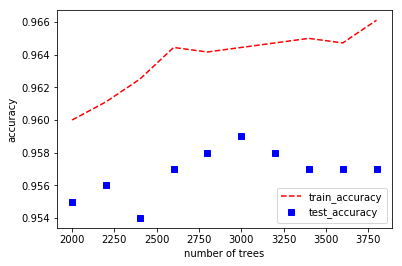

In [13]:
import matplotlib.pyplot as plt
train_accuracy, = plt.plot(numtrees, acc_train, 'r--')
test_accuracy, = plt.plot(numtrees, acc_test, 'bs')
plt.xlabel("number of trees")
plt.ylabel("accuracy")
plt.legend([train_accuracy, test_accuracy], ['train_accuracy', 'test_accuracy'])
plt.show()

In [69]:
print acc_test[5]

0.959


Based on my validation set, I choose 3000 as my nun tree because it gave me the largest accuracy value of 0.96

## Comparisons with XGBClassifier

To compare the performance of XGBclassier and the adaboost coded from scratch, I will only tune n_estimators for XGBClassifier and the grid is the same as the above. In the end, I will compare the best models I can get from adaboost and XGB.

In [62]:
from xgboost import XGBClassifier

In [64]:
acc_test_xgb = []
acc_train_xgb = []
n_estimators = range(2000,4000, 200)
for n in n_estimators:
    gbm = XGBClassifier(max_depth=4, learning_rate=0.3, n_estimators=n,
                            objective='binary:logistic', gamma=0., 
                            max_delta_step=0., subsample=0.9, colsample_bytree=0.9,
                            seed=0)
    gbm.fit(X,Y)
    Y_hat = gbm.predict(X)
    Y_test_hat = gbm.predict(X_test)
    acc_test_xgb.append(accuracy(Y_test, Y_test_hat))
    acc_train_xgb.append(accuracy(Y, Y_hat))

In [65]:
acc_test_xgb

[0.95399999999999996,
 0.95299999999999996,
 0.95299999999999996,
 0.95299999999999996,
 0.95299999999999996,
 0.95399999999999996,
 0.95199999999999996,
 0.95199999999999996,
 0.95099999999999996,
 0.95099999999999996]

In [66]:
acc_train_xgb 

[0.99916666666666665,
 0.99916666666666665,
 0.99916666666666665,
 0.99916666666666665,
 0.99916666666666665,
 0.99916666666666665,
 0.99916666666666665,
 0.99916666666666665,
 0.99916666666666665,
 0.99916666666666665]

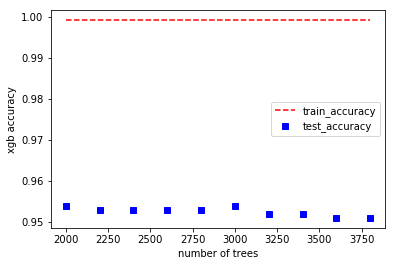

In [67]:
train_accuracy, = plt.plot(n_estimators, acc_train_xgb, 'r--')
test_accuracy, = plt.plot(n_estimators, acc_test_xgb, 'bs')
plt.xlabel("number of trees")
plt.ylabel("xgb accuracy")
plt.legend([train_accuracy, test_accuracy], ['train_accuracy', 'test_accuracy'])
plt.show()

In [71]:
print acc_test_xgb[5]

0.954


Based on my validation set, I choose 3000 as my num tree for xgb too, because it gave me the largest accuracy value of 0.954. The optimized accuracy is similar between xgboost and adboost on this dataset